# Load Libraries and Data

In [10]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [11]:
# Paths to data files
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Preprocessing

In [12]:
# Separate features and target
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)

X_test = test_df.drop(columns=['id'])

In [13]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')  # Keep numerical columns as they are

# Random Forests handle numerical features without scaling

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fitting RF Model

In [15]:
# Create a Pipeline that includes preprocessing and the Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

In [16]:
params = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': [None, 'balanced']
}

In [17]:
kappa_scorer = make_scorer(cohen_kappa_score)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=10,
    scoring=kappa_scorer,
    refit=True,
    verbose=2,
    n_jobs=-1
)

# Fit the model on the training data
gs.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Basic_Demos-Enroll_Season',
                                                                          'CGAS-Season',
                                                                          'Physical-Season',
                                                                          'Fitness_Endurance-Season',
                                                                          'FGC-Season',
                                                                          'BIA-Season',
                                                                          'PAQ_A-Season',
                                                                          'PAQ_C-Season',
                                                                          'PCIAT-Season',
                                                                          'SDS-Season',
                                                                          'PreInt_EduHx-Season'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': [None, 'balanced'],
                         'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring=make_scorer(cohen_kappa_score, response_method='predict'),
             verbose=2)

# Evaluating RF Model

In [18]:
# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")


Best Cross-Validation Accuracy: 0.9958
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


In [19]:
# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9975


In [20]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       1.00      1.00      1.00       146
           2       0.97      1.00      0.99        76
           3       1.00      0.71      0.83         7

    accuracy                           1.00       792
   macro avg       0.99      0.93      0.96       792
weighted avg       1.00      1.00      1.00       792



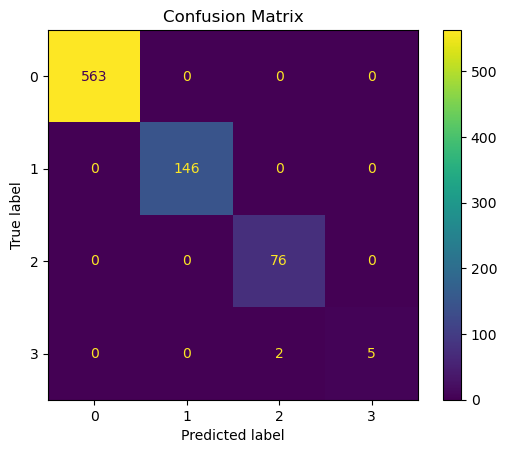

In [21]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Saving the RF Model

In [22]:
# Save the best model pipeline
joblib.dump(best_pipeline, 'best_rf_model.pkl')

print("\nBest Random Forest model has been saved successfully.")


Best Random Forest model has been saved successfully.
